### 잡음제거 : K-NN 활용
잡음이 있는 이미지를 읽어 픽셀 개수만큼의 분류 결과를 내어놓고, 이들을 모아 이미지를 구성한다.  
이렇게 분류 결과를 여러개 내어놓는 것을 다중출력분류(multi output classification)라고 한다.

In [1]:
#!pip install scikit-image

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.transform import resize

In [3]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj1/40/'
imgR, imgC, channel = 24, 24, 3
images = []

for i in range(40):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (imgR, imgC, channel))
    images.append(img)
    
def plot_images(nRow, nCol, img):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize=(nCol, nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1:
                axis = ax[j]
            else:
                axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol + j])

<Figure size 432x288 with 0 Axes>

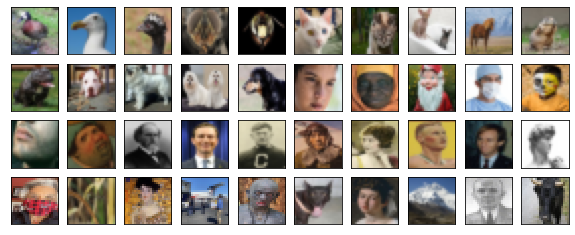

In [4]:
plot_images(4, 10, images)

<Figure size 432x288 with 0 Axes>

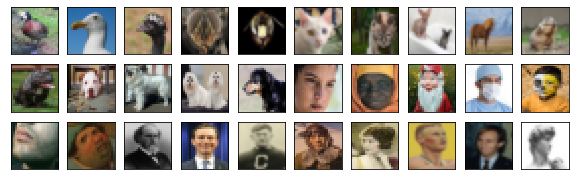

<Figure size 432x288 with 0 Axes>

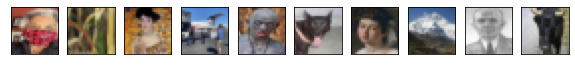

In [5]:
X = np.array(images[:30])        #훈련데이터 30개
X_test = np.array(images[30:])   #검증데이터 10개

plot_images(3, 10, X)
plot_images(1, 10, X_test)   #여기 훈련/검증 데이터들은 정답레이블로 사용

<Figure size 432x288 with 0 Axes>

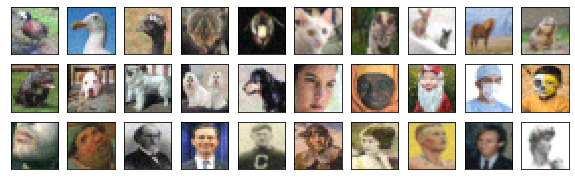

<Figure size 432x288 with 0 Axes>

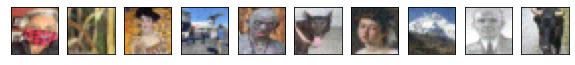

In [6]:
#노이즈(정규분포를 따름) 섞인 이미지 만들기
X_noisy = X + np.random.rand(len(X), imgR, imgC, channel) * 0.1
X_noisy = np.clip(X_noisy, 0, 1)              #0~1 사이를 벗어나지 않도록 클리핑
X_test_noisy = X_test + np.random.rand(len(X_test), imgR, imgC, channel) * 0.1
X_test_noisy = np.clip(X_test_noisy, 0, 1)

plot_images(3, 10, X_noisy)
plot_images(1, 10, X_test_noisy)   #노이즈 섞인 이미지들은 훈련용으로 사용

sklearn의 KNN 분류기는 모든 입력을 1차원 벡터 데이터로 취급하기 때문에  
입력 이미지 데이터 배열은 (이미지 개수, 이미지 픽셀 수) 형태가 되어야 한다.  
=> np.resize() 함수 사용

In [7]:
X_noisy_flat = X_noisy.reshape(-1, imgR*imgC*channel)                    #(30, 1728)   잡음섞인 이미지(X_noisy)를 한줄로 펼침
X_flat = np.array(X.reshape(-1, imgR*imgC*channel)*255, dtype=np.uint)   #(30, 1728)   깨끗한 이미지(X)를 한줄로 펼친 후 255 곱해 정수로

In [8]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_noisy_flat, X_flat)

KNeighborsClassifier()

<Figure size 432x288 with 0 Axes>

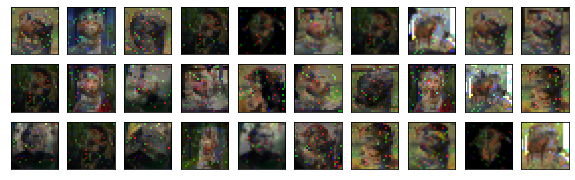

In [9]:
denoised_result = model.predict(X_noisy_flat)
denoised_result = denoised_result.reshape(-1, imgR, imgC, channel)

plot_images(3, 10, denoised_result)

훈련데이터가 30개밖에 없기 때문에, 데이터 증강을 위해 잡음을 추가하는 일을 반복해보자.  
=> 100번 반복하면 30 * 100 + 30 = 3030개 데이터를 얻을 수 있다.

In [10]:
n_aug = 100
X_noisy_aug = X + np.random.rand(len(X), imgR, imgC, channel) * 0.2
y_label = np.array(X * 255, dtype=np.uint)
y = y_label

print(X_noisy.shape)

for i in range(n_aug):
    noisy_data = X + np.random.randn(len(X), imgR, imgC, channel) * 0.2
    X_noisy_aug = np.append(X_noisy_aug, noisy_data, axis=0)
    y = np.append(y, y_label, axis=0)
    
X_noisy_aug = np.clip(X_noisy_aug, 0, 1)

X_noisy_aug.shape, y.shape

(30, 24, 24, 3)


((3030, 24, 24, 3), (3030, 24, 24, 3))

<Figure size 432x288 with 0 Axes>

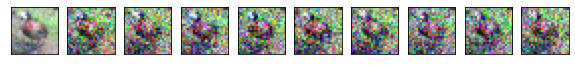

In [11]:
plot_images(1, 10, X_noisy_aug[0:300:30])   #같은 데이터, 다른 잡음 이미지 확인

<Figure size 432x288 with 0 Axes>

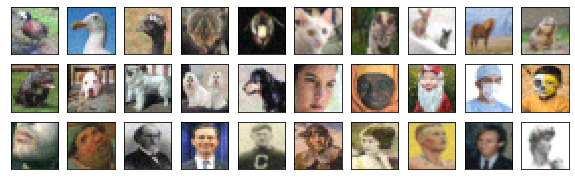

<Figure size 432x288 with 0 Axes>

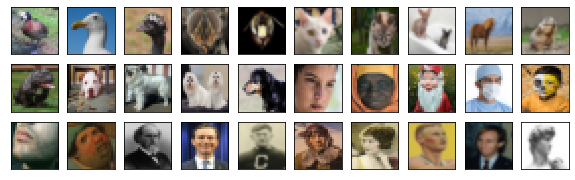

In [12]:
#증량된 데이터로 모델 학습
X_noisy_aug_flat = X_noisy_aug.reshape(-1, imgR*imgC*channel)   #(3030, 1728)
y_flat = y.reshape(-1, imgR*imgC*channel)                       #(3030, 1728)

model.fit(X_noisy_aug_flat, y_flat)

denoised_result = model.predict(X_noisy_flat)
denoised_result = denoised_result.reshape(-1, imgR, imgC, channel)

plot_images(3, 10, X_noisy)
plot_images(3, 10, denoised_result)

잡음이 더 심해져도 이미지를 잘 찾을 수 있을까?  

<Figure size 432x288 with 0 Axes>

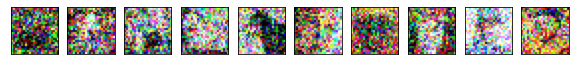

<Figure size 432x288 with 0 Axes>

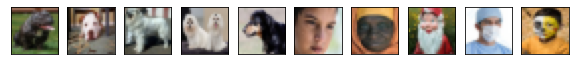

In [13]:
rand_idx = np.random.randint(0, 20)
data = X[rand_idx:rand_idx+10] + np.random.randn(10, imgR, imgC, channel) * 0.4
data = np.clip(data, 0, 1)
data_flat = data.reshape(-1, imgR*imgC*channel)

denoised = model.predict(data_flat)

denoised = denoised.reshape(-1, imgR, imgC, channel)
denoised = np.clip(denoised, 0, 255)

plot_images(1, 10, data)
plot_images(1, 10, denoised)

훈련에 사용하지 않은 새로운 데이터(X_test)도 잘 예측할 수 있을까?

<Figure size 432x288 with 0 Axes>

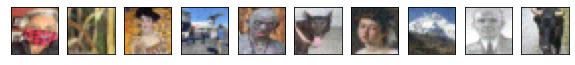

<Figure size 432x288 with 0 Axes>

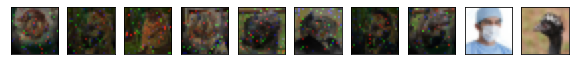

In [14]:
denoised = model.predict(X_test_noisy.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)

plot_images(1, 10, X_test_noisy)
plot_images(1, 10, denoised)   

데이터를 증강해 학습하기는 했지만, 30개를 반복 변형한 것이므로, 일반화하기는 힘들어 보인다.  
=> Keras api의 ImageDataGenerator 클래스를 이용해  
출력 이미지를 다양한 방법으로 왜곡시켜 정답 레이블을 증강시키고,  
입력은 증강된 정답 레이블 정보에 잡음을 넣어 생성해보자.

In [15]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rotation_range=360,        #이미지 회전
                                     zoom_range=0.1,            #확대
                                     shear_range=0.1,           #축소
                                     width_shift_range=0.1,     #기울이기
                                     height_shift_range=0.1,    #기울이기
                                     horizontal_flip=True,      #상하반전
                                     vertical_flip=True)        #좌우반전

y_aug = X.reshape(-1, imgR, imgC, channel)  #깨끗한 이미지 X를 증강한 데이터
it = image_generator.flow(y_aug)            #원본 이미지 데이터를 넘겨 iterator 생성 => next() 호출할 때마다 데이터 반환
nData = y_aug.shape[0]                      #원본 이미지 개수

<Figure size 432x288 with 0 Axes>

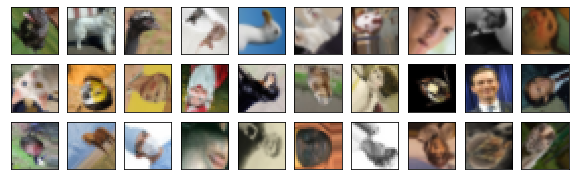

In [16]:
X_aug = y_aug + np.random.randn(nData, imgR, imgC, channel) * 0.1  #y_aug에 잡음 섞어 입력데이터 만들기

n_aug = 500

for i in range(n_aug):
    new_y = it.next()                 #image generator가 새로운 이미지 생성 => 새로운 레이블 
    new_X = new_y + np.random.randn(nData, imgR, imgC, channel) * 0.1   #new_y에 잡음 추가
    y_aug = np.append(y_aug, new_y)
    X_aug = np.append(X_aug, new_X)
    
y_aug = np.array(y_aug * 255, dtype=np.uint)
y_aug = y_aug.reshape(-1, imgR, imgC, channel)  
X_aug = X_aug.reshape(-1, imgR, imgC, channel)    

y_aug = np.clip(y_aug, 0, 255)
X_aug = np.clip(X_aug, 0, 1)

plot_images(3, 10, y_aug[30:])

<Figure size 432x288 with 0 Axes>

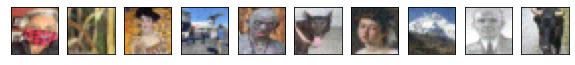

<Figure size 432x288 with 0 Axes>

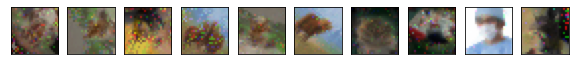

In [18]:
#증강된 데이터를 이용해 학습하기
X_aug_flat = X_aug.reshape(-1, imgR*imgC*channel)
y_aug_flat = y_aug.reshape(-1, imgR*imgC*channel)

model.fit(X_aug_flat, y_aug_flat)

denoised = model.predict(X_test_noisy.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)

plot_images(1, 10, X_test_noisy)
plot_images(1, 10, denoised)

조금 나아지긴 했지만, 일반화 능력을 높이기는 쉽지 않아 보인다.  
이번에는 검증데이터에 강한 잡음을 추가해 점점 잡음을 줄여보자.

<Figure size 432x288 with 0 Axes>

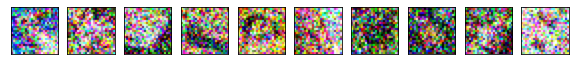

<Figure size 432x288 with 0 Axes>

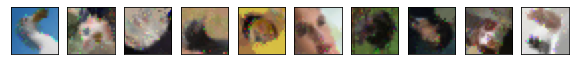

In [21]:
images = it.next()
X_test = images + np.random.randn(nData, imgR, imgC, channel) * 0.4
X_test = np.clip(X_test, 0, 1)

denoised = model.predict(X_test.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)

plot_images(1, 10, X_test)
plot_images(1, 10, denoised)

훈련에 사용되지 않은 새로운 데이터를 입력했지만,   
정답이 지금까지 봐왔던 것과 유사한 것들이기 때문에 잡음이 강해져도 답을 잘 찾는다.